In [1]:
print('Hello World')

Hello World


In [1]:
import os
import pandas
os.environ['JAVA_HOME'] = 'C:\java\jdk'
os.environ['SPARK_HOME'] = 'C:\spark-3.5.1-bin-hadoop3\spark-3.5.1-bin-hadoop3'
import findspark
findspark.init()
from pyspark import SparkContext

sc = SparkContext.getOrCreate()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [2]:
from pyspark.sql.functions import to_timestamp,col,lit
reviews_df = spark.read.json('yelp_dataset\yelp_academic_dataset_review.json').withColumn('Date',to_timestamp(col('date'),'yyyy-MM-dd HH:mm:ss'))
business_df = spark.read.json('yelp_dataset\yelp_academic_dataset_business.json')
checkin_df = spark.read.json('yelp_dataset\yelp_academic_dataset_checkin.json')
tip_df = spark.read.json('yelp_dataset\yelp_academic_dataset_tip.json')
user_df = spark.read.json('yelp_dataset\yelp_academic_dataset_user.json')


In [3]:
business_df = business_df.drop('attributes','hours')

In [5]:
business_df.show(5)

+--------------------+--------------------+--------------------+-------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|         business_id|          categories|         city|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+-------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|      1| 38.551126|  -90.335695|       The UPS Store|      63123|          15|  3.0|   MO|
|5255 E Broadway Blvd|tUFrWirKiKi_TAnsV...|Department Stores...|       Tucson|      0| 32.223236| -110.880452|              Target|      85711|          22

In [4]:
business_df.count()

150346

In [7]:
business_df.printSchema()

root
 |-- address: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- city: string (nullable = true)
 |-- is_open: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- stars: double (nullable = true)
 |-- state: string (nullable = true)



In [5]:
from pyspark.sql.functions import lower
business_df = business_df.where(lower(col('Categories')).rlike('.*restaurant.*'))
business_id_df = business_df.select(col('business_id')).filter(col('is_open') == 1)

In [6]:
business_df.count()

52286

In [7]:
business_id_df.count()


35004

In [8]:
from pyspark.sql.functions import mean,median,min,max
# business_df.filter(col('is_open') == 1).agg(mean(col('review_count')).alias('review_count_avg'),
#                                             median(col('review_count')).alias('review_count_median'),
#                                             min(col('review_count')).alias('review_count_min'),
#                                             max(col('review_count')).alias('review_count_max'),
#                                             mean(col('stars')).alias('stars_rating_avg'),
#                                             median(col('stars')).alias('stars_rating_median'),
#                                             min(col('stars')).alias('stars_rating_min'),
#                                             max(col('stars')).alias('stars_rating_max')).show()

In [9]:
def iqr_outliers(dataframe,column,factor=1.5):
    quartiles = dataframe.approxQuantile(column,[0.25,0.75],0.25)
    q1 , q3 = quartiles[0],quartiles[1]
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
    dataframe = dataframe.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    return dataframe

business_df = iqr_outliers(business_df.filter(col('is_open') == 1),'review_count')

In [13]:
# business_df.agg(mean(col('review_count')).alias('review_count_avg'),
#                                             median(col('review_count')).alias('review_count_median'),
#                                             min(col('review_count')).alias('review_count_min'),
#                                             max(col('review_count')).alias('review_count_max'),
#                                             mean(col('stars')).alias('stars_rating_avg'),
#                                             median(col('stars')).alias('stars_rating_median'),
#                                             min(col('stars')).alias('stars_rating_min'),
#                                             max(col('stars')).alias('stars_rating_max')).show()

In [10]:
business_df.show(5)

+-------------------+--------------------+--------------------+------------+-------+-------------+-------------+--------------------+-----------+------------+-----+-----+
|            address|         business_id|          categories|        city|is_open|     latitude|    longitude|                name|postal_code|review_count|stars|state|
+-------------------+--------------------+--------------------+------------+-------+-------------+-------------+--------------------+-----------+------------+-----+-----+
|        935 Race St|MTSW4McQd7CbVtyjq...|Restaurants, Food...|Philadelphia|      1|   39.9555052|  -75.1555641|  St Honore Pastries|      19107|          80|  4.0|   PA|
|      615 S Main St|CF33F8-E6oudUQ46H...|Burgers, Fast Foo...|Ashland City|      1|    36.269593|   -87.058943|      Sonic Drive-In|      37015|           6|  2.0|   TN|
|2312 Dickerson Pike|bBDDEgkFA1Otx9Lfe...|Ice Cream & Froze...|   Nashville|      1|   36.2081024|  -86.7681696|      Sonic Drive-In|      37207|

In [11]:
from pyspark.sql.functions import sum
# business_df.select(col('name'),col('review_count'),col('stars')).groupby(col('name')).agg(
#     sum(col('review_count')).alias('review_count_sum'),
#     mean(col('stars')).alias('avg_star_ratings')
# ).orderBy(col('review_count_sum'),ascending = [False]).show(10,truncate=False)

In [16]:
# business_df.select(col('name'),col('review_count'),col('stars')).groupby(col('name')).agg(
#     sum(col('review_count')).alias('review_count_sum'),
#     mean(col('stars')).alias('avg_star_ratings')
# ).orderBy(col('avg_star_ratings'),ascending = [False]).show(10,truncate=False)

In [15]:
from pyspark.sql.functions import *
# checkin_count_df = (checkin_df.withColumn('count',length(col('date'))-length(regexp_replace(col('date'), ',', ''))+1)
#             .groupby(col('business_id'))
#             .agg(sum(col('count')).alias('check_id_count'))
#             ).na.drop()


In [18]:
# checkin_count_df.show(5)

In [19]:
# tip_count_df = tip_df.groupBy(col('business_id')).agg(count(col('text')).alias('tip_count')).na.drop()

In [20]:
# tip_count_df.show(5)

In [12]:
new_business_df = (business_df.join(checkin_df,checkin_df.business_id ==  business_df.business_id,"left")
 .join(tip_df,tip_df.business_id ==  business_df.business_id,"left")
)

In [22]:
new_business_df.show(5)

+-------------------+--------------------+--------------------+------------+-------+----------+-----------+--------------+-----------+------------+-----+-----+--------------------+--------------------+--------------------+----------------+-------------------+--------------------+--------------------+
|            address|         business_id|          categories|        city|is_open|  latitude|  longitude|          name|postal_code|review_count|stars|state|         business_id|                date|         business_id|compliment_count|               date|                text|             user_id|
+-------------------+--------------------+--------------------+------------+-------+----------+-----------+--------------+-----------+------------+-----+-----+--------------------+--------------------+--------------------+----------------+-------------------+--------------------+--------------------+
|      615 S Main St|CF33F8-E6oudUQ46H...|Burgers, Fast Foo...|Ashland City|      1| 36.269593

In [13]:
new_business_df.count()

492540

In [20]:
tip_count_df = (new_business_df.select(col('name'),tip_df.user_id)
    .groupby(col('name')).agg(
    count(tip_df.user_id).alias('tip_count')
))

In [ ]:
star_ratings_df = (new_business_df.select(col('name'),col('review_count'),col('stars'),checkin_df.date,tip_df.user_id)
    .groupby(col('name')).agg(
    sum(col('review_count')).alias('review_count_sum'),
    (round(mean(col('stars'))*2)/2).alias('avg_star_ratings'),
    sum(length(checkin_df.date)-length(regexp_replace(checkin_df.date, ',', ''))+1).alias('check_id_count'),
    count(tip_df.user_id).alias('tip_count')
    )
).groupby(col('avg_star_ratings')).agg(
    round(avg(col('review_count_sum')),4).alias('avg_review_count'),
    round(avg(col('check_id_count')),4).alias('avg_checkin_count'),
    round(avg(col('tip_count')),4).alias('avg_tip_count')
).sort(col('avg_star_ratings'),ascending = [True])

In [ ]:
import matplotlib.pyplot as plt

ratings_review_df = star_ratings_df.toPandas()
# ratings_review_df.head(5)
# plt.barh(display_avg_review['avg_star_ratings'],display_avg_review['avg_review_count'])

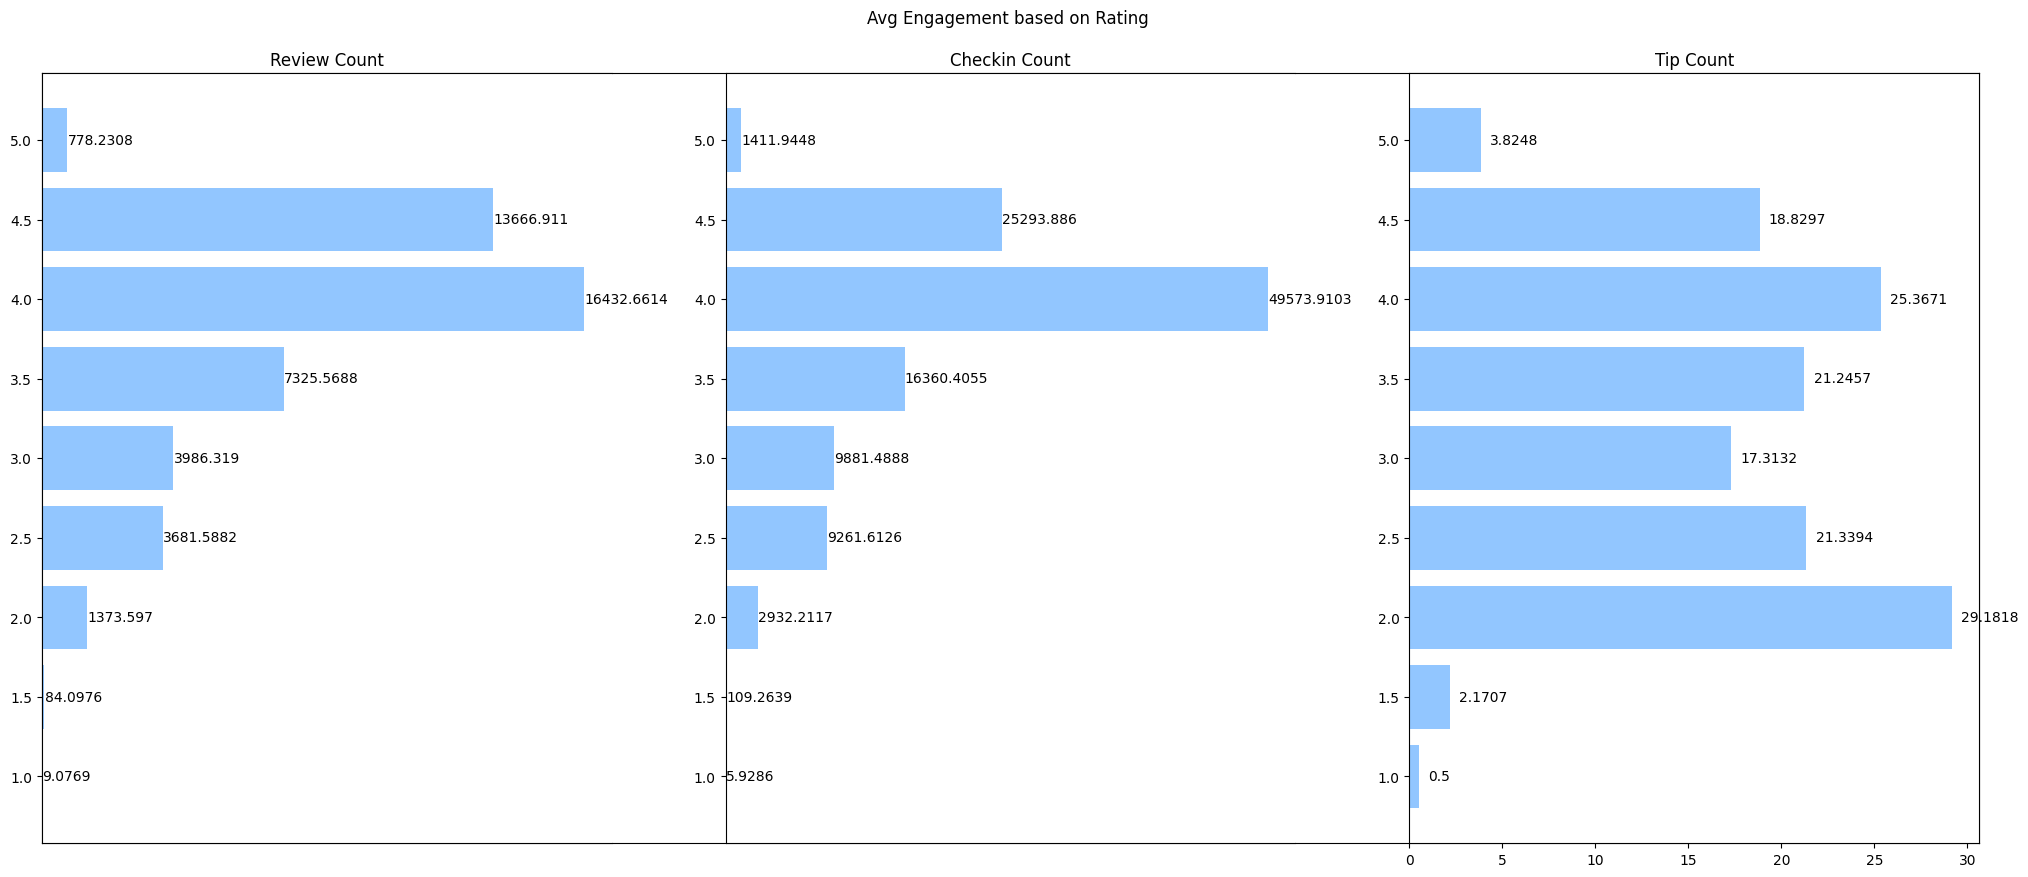

In [25]:
plt.figure(figsize=(25,10))
plt.style.use('seaborn-v0_8-pastel')
plt.title('Avg Engagement based on Rating \n\n')
plt.yticks([])
plt.xticks([])
plt.subplot(1,3,1)
plt.title('Review Count')
plt.barh(ratings_review_df['avg_star_ratings'].astype('str'),ratings_review_df['avg_review_count'])
plt.gca().spines['right'].set_visible(False)
for i,value in enumerate(ratings_review_df['avg_review_count']):
    plt.text(value+3,i,str(value),color = 'black', va = 'center')

plt.xticks([])
plt.subplot(1,3,2)
plt.title('Checkin Count')
plt.barh(ratings_review_df['avg_star_ratings'].astype('str'),ratings_review_df['avg_checkin_count'])
plt.gca().spines['right'].set_visible(False)
for i,value in enumerate(ratings_review_df['avg_checkin_count']):
    plt.text(value+3,i,str(value),color = 'black', va = 'center')

plt.xticks([])
plt.subplot(1,3,3)
plt.title('Tip Count')
plt.barh(ratings_review_df['avg_star_ratings'].astype('str'),ratings_review_df['avg_tip_count'])
for i,value in enumerate(ratings_review_df['avg_tip_count']):
    plt.text(value+0.5,i,str(value),color = 'black', va = 'center')


In [26]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [27]:
engagement_df = (new_business_df.select(col('name'),col('review_count'),col('stars'),checkin_df.date,tip_df.user_id)
    .groupby(col('name')).agg(
    sum(col('review_count')).alias('review_count_sum'),
    (round(mean(col('stars'))*2)/2).alias('avg_star_ratings'),
    sum(length(checkin_df.date)-length(regexp_replace(checkin_df.date, ',', ''))+1).alias('check_id_count'),
    count(tip_df.user_id).alias('tip_count')
)).na.drop().toPandas()

In [28]:
engagement_df[['review_count_sum','check_id_count','tip_count']].corr()

,review_count_sum,check_id_count,tip_count
review_count_sum,1.000000,0.580413,0.533938
check_id_count,0.580413,1.000000,0.418028
tip_count,0.533938,0.418028,1.000000


<Axes: >

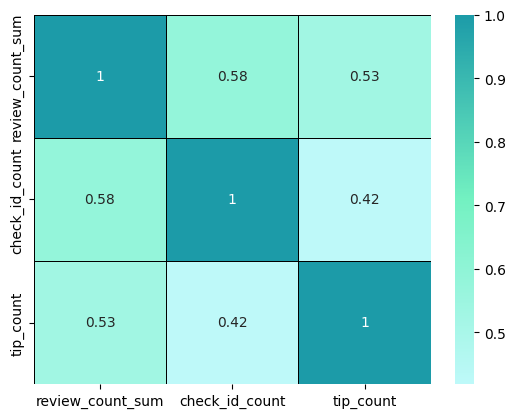

In [29]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

colors = ['#BEF9F9','#73F1C1','#1C9BA8']
custom_cmap = LinearSegmentedColormap.from_list('mycmap',colors)
sns.heatmap(engagement_df[['review_count_sum','check_id_count','tip_count']].corr(), cmap = custom_cmap, annot=True,linewidths=0.5,linecolor='k')

In [30]:
engg_df = (new_business_df.select(col('name'),col('review_count'),col('stars'),checkin_df.date,tip_df.user_id)
    .groupby(col('name')).agg(
    sum(col('review_count')).alias('review_count_sum'),
    (round(mean(col('stars'))*2)/2).alias('avg_star_ratings'),
    sum(length(checkin_df.date)-length(regexp_replace(checkin_df.date, ',', ''))+1).alias('check_id_count'),
    count(tip_df.user_id).alias('tip_count'))   
).na.drop()



In [31]:
engg_df = engg_df.withColumn('category',when(col('avg_star_ratings')>= 3.0,'high_rated').otherwise('low_rated')).toPandas()

In [32]:
engg_df.groupby('category')[['review_count_sum','check_id_count','tip_count']].mean()

,review_count_sum,check_id_count,tip_count
category,,,
high_rated,11551.063865,28867.509953,21.045802
low_rated,3033.443972,7324.254610,22.636879


In [33]:
import numpy as np
def calculate_success_score(df):
    success_score = []
    for index,row in df.iterrows():
        score = row['avg_star_ratings']*np.log(row['review_count_sum']+1)
        success_score.append(score)
    return success_score



In [34]:
city_df = (business_df.select(col('state'),col('city'),col('review_count'),col('stars'),col('business_id'))
    .groupby(col('state'),col('city')).agg(
    sum(col('review_count')).alias('review_count_sum'),
    (round(mean(col('stars'))*2)/2).alias('avg_star_ratings'),
    count(col('business_id')).alias('busines_count')    
    ).sort(col('review_count_sum'),ascending = [False])
).toPandas().head(10)



In [35]:
city_df['success_score'] = calculate_success_score(city_df)


In [36]:
city_df

,state,city,review_count_sum,avg_star_ratings,busines_count,success_score
0,PA,Philadelphia,495404,3.5,3527,45.895958
1,LA,New Orleans,386992,4.0,1392,51.464648
2,TN,Nashville,260980,3.5,1681,43.652710
3,FL,Tampa,236140,3.5,1965,43.302645
4,AZ,Tucson,192649,3.5,1643,42.590206
5,IN,Indianapolis,186614,3.5,1904,42.478810
6,NV,Reno,151460,3.5,798,41.748292
7,CA,Santa Barbara,127068,4.0,446,47.009942
8,MO,Saint Louis,125866,3.5,958,41.100434
9,ID,Boise,55551,3.5,603,38.237762


Importing pandas and other plotting libraries

In [37]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from datetime import datetime
# import numpy as np
# import sqlite3
import folium
from geopy.geocoders import Nominatim
# from matplotlib.colors import LinearSegmentedColormap
#from Ipython.display import display
import warnings
warnings.filterwarnings('ignore')

Making SQL Views from pyspark

In [38]:
# business_df.createOrReplaceTempView('Business')
# checkin_df.createOrReplaceTempView('Checkin')
# reviews_df.createOrReplaceTempView('Reviews')
# tip_df.createOrReplaceTempView('Tip')
# user_df.createOrReplaceTempView('Users')

In [39]:
# spark.sql('''select business_id from Business where lower(categories) like '%restaurent%' ''').show(5)

In [40]:
# spark.sql('''select * from Reviews where Date >= '2020-01-01' ''').show(5)

In [41]:
# spark.sql('''select * from Business ''').show(5)

In [42]:
# spark.sql('''select * from Tip ''').show(5)

In [43]:
# spark.sql('''select * from Checkin ''').show(5)

In [44]:
# spark.sql('''select * from User ''').show(5)

In [45]:
# spark.sql('''select * 
#           from Business 
#           join Checkin 
#           on Checkin.business_id = business.business_id''').show(5)

next steps -
take data from any one state. CA / TX
based on latitude / longitude, run a kmeans ml model, to cluster restaurent 
    a) based on stars
    b) based on review counts
